# autoTS: Spectral Analysis template

This notebook describes a workflow for spectral analysis. It can be used as a template for similar analysis. Each cell represents a worflow component (input not written to disk). 

**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect outliers
    * Remove outliers
    * Hypothesize over missing values
* Analysis
    * Spectral analysis
    * Significance testing 
* Visualization
    * Periodogram
    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [1]:
import pyleoclim as pyleo
%matplotlib inline

Functions to handle writing in and out of "components"

In [6]:
import json

def transform(obj_dict):
    for k in obj_dict.keys():
        if isinstance(obj_dict[k],(np.ndarray)):
            obj_dict[k] = obj_dict[k].tolist()
        elif isinstance(obj_dict[k],(pyleo.Series,pyleo.PSD)):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
        elif isinstance(obj_dict[k],pyleo.MultiplePSD):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
            c=[]
            idx = np.arange(0,len(obj_dict[k]['psd_list']),1).tolist()
            for item in idx:
                PSD_dict=PyleoObj_to_json(obj_dict[k]['psd_list'][item],dict_return=True)
                c.append(PSD_dict)
            obj_dict[k]['psd_list']=c            
        elif isinstance(obj_dict[k],(dict)):
            obj_dict[k]=transform(obj_dict[k])
    return obj_dict


def list_to_array(obj_dict):
    for k in obj_dict:
        if type(obj_dict[k])is dict:
            obj_dict[k]=list_to_array(obj_dict[k])
        elif type(obj_dict[k]) is list:
            obj_dict[k]=np.array(obj_dict[k])
        else:
            obj_dict[k]=obj_dict[k]
    return obj_dict

def PyleoObj_to_json(PyleoObj,filename='trial',dict_return=False):
    obj_dict = PyleoObj.__dict__
    obj_dict = transform(obj_dict)
    if dict_return == False:
        with open('./IntermediateOutputs/'+filename+'.json','w') as f:
            json.dump(obj_dict, f)
            f.close()
    elif dict_return == True:
        return  obj_dict

def json_to_Series(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    ts = pyleo.Series(time=np.array(t['time']),
                     value=np.array(t['value']),
                     time_name=t['time_name'],
                     time_unit=t['time_unit'],
                     value_name=t['value_name'],
                     value_unit=t['value_unit'],
                     label=t['label']) 
    return ts

def PSD_to_MultiplePSD(series_list):
    idx = np.arange(0,len(series_list),1).tolist()
    d=[]
    for item in idx:
        t=series_list[item]
        PSD_obj=pyleo.PSD(frequency=np.array(t['frequency']),
                        amplitude=np.array(t['amplitude']),
                        label=t['label'],
                        timeseries = t['timeseries'],
                        spec_method = t['spec_method'],
                        spec_args =  t['spec_args'],
                        signif_qs = t['signif_qs'],
                    signif_method = t['signif_method'])
        d.append(PSD_obj)
    MPSD=pyleo.MultiplePSD(psd_list=d)
    return MPSD
        

def json_to_PSD(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    t = list_to_array(t)
    
    #Deal with significance testing 
    if type(t['signif_qs']) is dict:
        c = PSD_to_MultiplePSD(t['signif_qs']['psd_list'])
    else:
        c = t['signif_qs']
        
    psd = pyleo.PSD(frequency=np.array(t['frequency']),
                    amplitude=np.array(t['amplitude']),
                    label=t['label'],
                    timeseries = pyleo.Series(time=np.array(t['timeseries']['time']),
                                             value=np.array(t['timeseries']['value']),
                                             time_name=t['timeseries']['time_name'],
                                             time_unit=t['timeseries']['time_unit'],
                                             value_name=t['timeseries']['value_name'],
                                             value_unit=t['timeseries']['value_unit'],
                                             label=t['timeseries']['label']),
                    spec_method = t['spec_method'],
                    spec_args =  t['spec_args'],
                    signif_qs = c,
                    signif_method = t['signif_method'])
    
    return  psd

## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

Text(0, 0.5, 'Value')

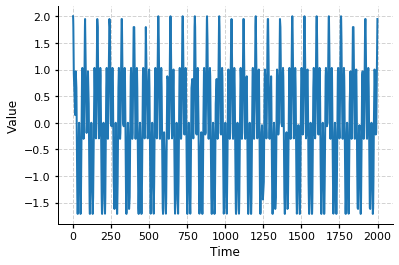

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)


del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

### Step 2: Create a series object for Pyleoclim

Create the time series object and write it as an intermediate output in JSON. 

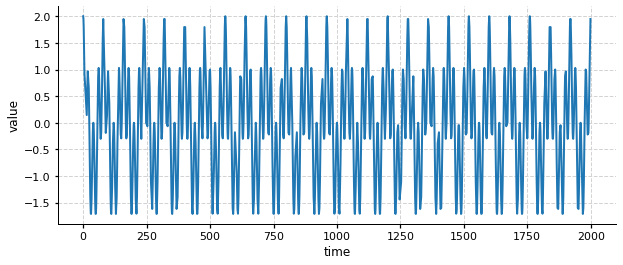

In [7]:
import json

ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)
PyleoObj_to_json(ts,'ts')

fig,ax = ts.plot()

## Preprocessing

### Standarize

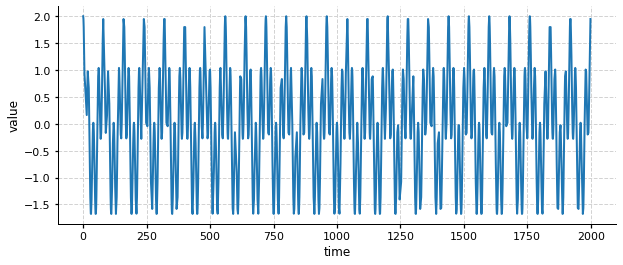

In [9]:
ts = json_to_Series('ts') #load JSON
ts_std = ts.standardize()

fig,ax = ts_std.plot()

In [26]:
import statsmodels.api as sm

In [27]:
scale = 1
g = 0.5
ar = np.r_[1,-g]
ma = np.r_[1,0.0]
ar1_series = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000, scale=1, burnin=50)


In [39]:
ts =pyleo.Series(time=np.arange(1,1001),value=ar1_series)

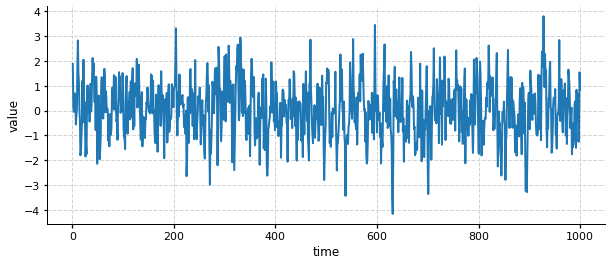

(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3e6cd20df0>)

In [40]:
ts.plot()

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:14<00:00, 13.77it/s]


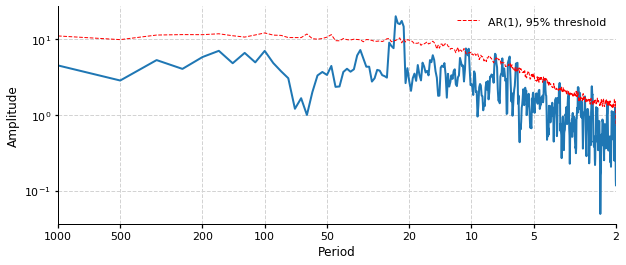

In [33]:
fig, ax = ts.spectral(method='mtm').signif_test().plot()

In [42]:
get_mle(ts.value,ts.time)

array([4.44450765, 3.51059187])

### Analysis

### Spectral Analysis
#### WWZ

This method doesn't require require evenly-spaced data in time, and therefore  uses the detrended time series.

In [10]:
%%time

psd_wwz = ts_std.spectral(method='wwz')
PyleoObj_to_json(psd_wwz,'psd_wwz')

CPU times: user 46.1 s, sys: 431 ms, total: 46.6 s
Wall time: 26.9 s


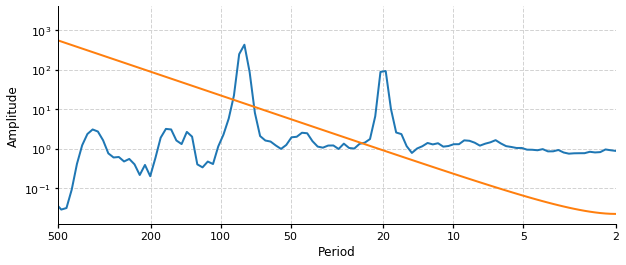

In [24]:
f = np.array(psd_wwz.frequency)

fig, ax = psd_wwz.plot(mute=True) 
ax.plot(1/f,res[:,2]) 
pyleo.showfig(fig) 

In [22]:
psd_wwz.frequency

[0.0010005002501250627,
 0.001053675321085904,
 0.0011096765664243486,
 0.0011686541930224646,
 0.0012307663910302977,
 0.0012961797581644626,
 0.0013650697465575532,
 0.001437621133356929,
 0.0015140285163350983,
 0.0015944968358410582,
 0.001679241924492545,
 0.0017684910860836082,
 0.0018624837052602214,
 0.0019614718895992465,
 0.0020657211458129238,
 0.0021755110918925792,
 0.0022911362071017212,
 0.002412906621830108,
 0.002541148949427389,
 0.002676207162247404,
 0.0028184435142529426,
 0.0029682395126555275,
 0.0031259969411964014,
 0.003292138937813307,
 0.0034671111295836586,
 0.0036513828279882204,
 0.0038454482877011997,
 0.004049828032283167,
 0.004265070250332528,
 0.004491752265840327,
 0.0047304820866921685,
 0.0049819000354706915,
 0.005246680466932707,
 0.005525533576767645,
 0.005819207306488755,
 0.006128489349566409,
 0.006454209264184336,
 0.0067972406982856485,
 0.007158503732876667,
 0.007538967349873842,
 0.00793965203111295,
 0.00836163249549169,
 0.0088060405

In [41]:
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import minimize
from statsmodels import tsa  

def get_starting_value(y,time):
    delta = np.diff(time)
    auto_reg_model = tsa.ar_model.AutoReg(y,1).fit()
    b= (auto_reg_model.sigma2)
    a=(auto_reg_model.params[1])
    my_tau = abs(np.median(delta)/math.log(a))
    my_sigma2 = abs(b/(1-a**2))
    res = [math.log(my_tau),math.log(my_sigma2)]
    return res

def neg_log_likelihood(theta_R,y,time):
    tau = np.exp(theta_R[0])
    sigma2 = np.exp(theta_R[1])
    delta = np.diff(time)
    phi = np.exp(-delta/tau)
    n = len(y)
    temp1 = y[1:n]
    temp2 = y[0:n-1]
    temp = [i-j for i,j in zip(temp1,temp2)]
  
    a = np.array([i**2 for i in temp])
    a/=(1-phi**2)
    #a = np.array([(i/(1-phi**2)) for i in a])

   
    
    #log(2 * pi) + log(sigma2) + 1 / n * sum(log(1 - phi ^ 2)) + 1 / (sigma2 * n) * (Xt[1] ^ 2 + sum(a)
    out = np.log(2*np.pi)+np.log(sigma2)+ 1/n*sum(np.log(1-phi**2))+1/(sigma2*n)*(y[0]**2+sum(a))
    #print(out)
    
    return out



def get_mle(y,time):
    start = get_starting_value(y,time)
    out = (minimize(neg_log_likelihood,start,args=(y,time)))
    out = np.exp(out.x)
    return out



def get_psd(f, delta, tau, sigma2):
    phi = np.exp(-delta / tau)
    up = sigma2 * (1 - phi ** 2)
    btm = (1 + phi ** 2) - (2 * phi * np.cos(2 * np.pi * np.array(f)))
    return up / btm




def get_V_psd_random_delta(f, delta_for_psd,delta, tau, sigma2):
    deriv_S = get_deriv_S(f=f, delta_for_psd=delta_for_psd, tau=tau, sigma2=sigma2)
    invH = get_invH(delta=delta, tau=tau, sigma2=sigma2)
    Sigma = get_Sigma(delta=delta, tau=tau, sigma2=sigma2)
    a = np.dot(np.transpose(deriv_S), invH)
    b = np.dot(a, Sigma)
    c = np.dot(b, invH)
    res = np.dot(c, deriv_S)
    return res


def get_V_theta_random_delta(delta,tau,sigma2):
    invH = get_invH(delta,tau,sigma2)
    Sigma = get_Sigma(delta,tau,sigma2)
    a = np.dot(invH,Sigma)
    b = np.dot(a,invH)
    return b

def get_deriv_S(f, delta_for_psd, tau, sigma2):
    delta = delta_for_psd
    S1 = (2 * delta * sigma2 * np.exp(delta / tau) * (
                np.cos(2 * np.pi * f) - 2 * np.exp(delta / tau) + np.exp((2 * delta) / tau) * np.cos(
            2 * np.pi * f))) / (
                     tau ** 2 * (np.exp((2 * delta) / tau) - 2 * np.exp(delta / tau) * np.cos(2 * f * np.pi) + 1) ** 2)
    S2 = (np.exp((2 * delta) / tau) - 1) / (
                np.exp((2 * delta) / tau) - 2 * np.exp(delta / tau) * np.cos(2 * np.pi * f) + 1)
    deriv_S = np.array([S1, S2])
    return deriv_S


def get_Sigma(delta, tau, sigma2):
    phi = np.exp(-delta / tau)

    Sigma11 = 4 / tau ** 4 * np.mean(delta ** 2 * phi ** 2 * (1 + phi ** 2) / (1 - phi ** 2) ** 2)

    Sigma12 = -4 / (tau ** 2 * sigma2) * np.mean(delta * phi ** 2 / (1 - phi ** 2))
    #print(np.mean(delta * phi ** 2 / (1 - phi ** 2)))
    Sigma21 = Sigma12
    Sigma22 = 2 / sigma2 ** 2
    mat = np.zeros((2, 2))
    mat[0] = [Sigma11, Sigma12]
    mat[1] = [Sigma21, Sigma22]
    return mat


def get_invH(delta, tau, sigma2):
    phi = np.exp(-delta / tau)

    H11 = -2 / tau ** 4 * np.mean((phi ** (-2) + 1) * delta ** 2 / (phi ** (-2) - 1) ** 2)
    H12 = -2 / (sigma2 * tau ** 2) * np.mean(delta / (1 - phi ** (-2)))
    H21 = H12
    H22 = -1 / sigma2 ** 2

    a = H11
    b = H12
    c = H21
    d = H22
    mat = np.zeros((2, 2))
    mat[0] = [d, -b]
    mat[1] = [-c, a]
    mat = 1 / (a * d - b * c) * mat
    return mat


def analysis_random_data(y, time, freq, delta_for_psd=None, alpha_tau=0.05, alpha_sigma2=0.05,
                         probs_psd=[0.8, 0.9, 0.95, 0.99]):
    n = len(y)
    if not delta_for_psd:
        delta_for_psd = np.median(np.diff(time))
    theta_hat = get_mle(y, time)
    V_theta = get_V_theta_random_delta(delta=np.diff(time), tau=theta_hat[0], sigma2=theta_hat[1])
    ci_tau = (theta_hat[1] + [-1, 1]) * (norm.ppf(1 - alpha_tau / 2) * math.sqrt(V_theta[0, 0] / n))
   
    ci_sigma2 = (theta_hat[1] + [-1, 1] )* (norm.ppf(1 - alpha_sigma2 / 2) * math.sqrt(V_theta[1, 1] * n))
    print(ci_sigma2)
    psd_hat = get_psd(freq, delta_for_psd, tau=theta_hat[0], sigma2=theta_hat[1])
    pointwise_ci_psd = np.zeros((len(freq), len(probs_psd)))
    
    for i in range(0, len(freq)):
        var_psd = get_V_psd_random_delta(freq[i], delta_for_psd, delta=np.diff(time), tau=theta_hat[0], sigma2=theta_hat[1])
        pointwise_ci_psd[i] = norm.ppf(probs_psd, psd_hat[i], math.sqrt(var_psd / n))


    return pointwise_ci_psd







In [14]:
res =analysis_random_data(signal_unevenly,time_unevenly,psd_wwz.frequency)

[1937327.11328217 2065444.84521052]


In [17]:
res[:,2]

array([2.26591880e+03, 2.03378359e+03, 1.82645491e+03, 1.64114105e+03,
       1.47537494e+03, 1.32697693e+03, 1.19402176e+03, 1.07480901e+03,
       9.67836868e+02, 8.71778725e+02, 7.85462343e+02, 7.07851234e+02,
       6.38028112e+02, 5.75180208e+02, 5.18586319e+02, 4.67605444e+02,
       4.21666870e+02, 3.80261564e+02, 3.42934732e+02, 3.09279378e+02,
       2.78930749e+02, 2.51561527e+02, 2.26877658e+02, 2.04614720e+02,
       1.84534751e+02, 1.66423466e+02, 1.50087800e+02, 1.35353738e+02,
       1.22064386e+02, 1.10078254e+02, 9.92677228e+01, 8.95176690e+01,
       8.07242332e+01, 7.27937139e+01, 6.56415717e+01, 5.91915329e+01,
       5.33747819e+01, 4.81292331e+01, 4.33988738e+01, 3.91331724e+01,
       3.52865428e+01, 3.18178622e+01, 2.86900351e+01, 2.58696007e+01,
       2.33263769e+01, 2.10331406e+01, 1.89653382e+01, 1.71008241e+01,
       1.54196259e+01, 1.39037308e+01, 1.25368942e+01, 1.13044662e+01,
       1.01932357e+01, 9.19128874e+00, 8.28788190e+00, 7.47332710e+00,
      

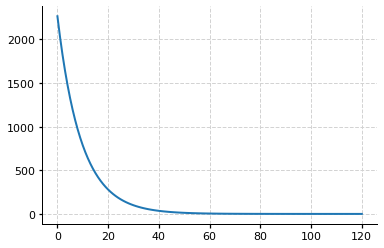

In [18]:
plt.plot(res[:,2])

In [139]:
tau = pyleo.tsmodel.tau_estimation(ts_std.value,ts_std.time)

In [140]:
tau

12.292924893624246

In [142]:
f = psd_wwz.frequency

In [172]:
psd_wwz_anyalytical =  get_psd(f,np.median(np.diff(ts_std.time)),tau,np.var(ts_std.value))

In [176]:
psd_wwz.amplitude

[4.426118466004044,
 4.217883987463049,
 3.9793929057842394,
 3.802263884543361,
 3.7716663503811962,
 3.931464462003619,
 4.250839682157985,
 4.609158347600374,
 4.816666321226129,
 4.679084728302962,
 4.091803435288242,
 3.1197196024298472,
 2.001462527601204,
 1.042133830895278,
 0.4402996668578534,
 0.18225594736936684,
 0.11395980882101217,
 0.12235107340853346,
 0.21530222972658705,
 0.4356718924684161,
 0.7785819692112894,
 1.1518486904680827,
 1.2993666926894625,
 0.9937237762710054,
 0.5531301250782664,
 0.724826867070374,
 1.4313952298717305,
 1.235492667238557,
 0.44481485421040157,
 1.0985173291161145,
 1.3311173747142913,
 1.1037290334922703,
 1.1283730161882708,
 1.2305291182068399,
 1.077658479691393,
 0.3495447904816855,
 0.24248877714841463,
 0.489708815605619,
 1.5037003251348768,
 3.450700837710048,
 3.6561590440527545,
 2.2077728969818944,
 1.1843398322159029,
 1.0050691610256248,
 1.2792577376797454,
 2.1652815788727606,
 5.126954556872632,
 21.12273156748478,
 252

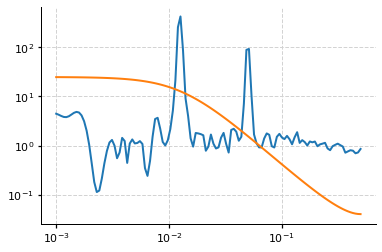

In [183]:

plt.loglog(f,psd_wwz.amplitude) 
plt.loglog(f,psd_wwz_anyalytical)

In [177]:
plt.plot(psd_wwz_anyalytical

array([24.45301984, 24.43715536, 24.41958423, 24.40012574, 24.37858071,
       24.35472973, 24.32833131, 24.29911986, 24.26680361, 24.23106229,
       24.19154482, 24.14786679, 24.09960796, 24.04630961, 23.98747193,
       23.92255147, 23.85095858, 23.77205514, 23.68515252, 23.58950989,
       23.48433314, 23.36877441, 23.24193259, 23.10285484, 22.95053958,
       22.78394096, 22.60197537, 22.40353007, 22.18747435, 21.9526735 ,
       21.69800574, 21.42238239, 21.12477126, 20.80422326, 20.45990196,
       20.09111572, 19.69735156, 19.27831003, 18.83393974, 18.36447003,
       17.87044027, 17.3527238 , 16.81254473, 16.25148579, 15.67148579,
       15.07482538, 14.4641008 , 13.84218548, 13.21218048, 12.57735533,
       11.94108149, 11.30676128, 10.67775543, 10.05731248,  9.44850321,
        8.85416273,  8.2768425 ,  7.71877376,  7.18184298,  6.6675795 ,
        6.17715458,  5.71139066,  5.27077938,  4.85550642,  4.4654814 ,
        4.10037093,  3.75963333,  3.44255333,  3.14827581,  2.87

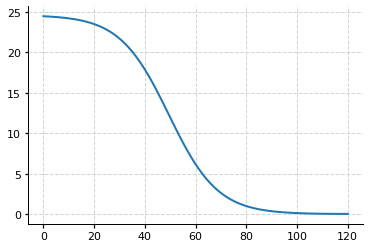

In [174]:
plt.plot(psd_wwz_anyalytical)

In [159]:
signif_wwz = analysis_random_data(ts_std.value,ts_std.time,f)

[2406590.11581861 2552786.14477558]


In [169]:
signif_wwz[:,2]

array([2.21456227e+03, 1.98893694e+03, 1.78726883e+03, 1.60686555e+03,
       1.44535125e+03, 1.30062957e+03, 1.17085066e+03, 1.05438194e+03,
       9.49782177e+02, 8.55778305e+02, 7.71244942e+02, 6.95186149e+02,
       6.26719338e+02, 5.65061139e+02, 5.09515034e+02, 4.59460620e+02,
       4.14344304e+02, 3.73671262e+02, 3.36998505e+02, 3.03928886e+02,
       2.74105914e+02, 2.47209251e+02, 2.22950789e+02, 2.01071217e+02,
       1.81337001e+02, 1.63537721e+02, 1.47483716e+02, 1.33003983e+02,
       1.19944311e+02, 1.08165607e+02, 9.75424036e+01, 8.79615117e+01,
       7.93208177e+01, 7.15281958e+01, 6.45005311e+01, 5.81628385e+01,
       5.24474686e+01, 4.72933917e+01, 4.26455510e+01, 3.84542799e+01,
       3.46747756e+01, 3.12666240e+01, 2.81933711e+01, 2.54221357e+01,
       2.29232604e+01, 2.06699961e+01, 1.86382175e+01, 1.68061664e+01,
       1.51542197e+01, 1.36646805e+01, 1.23215890e+01, 1.11105528e+01,
       1.00185927e+01, 9.03400439e+00, 8.14623322e+00, 7.34576156e+00,
      

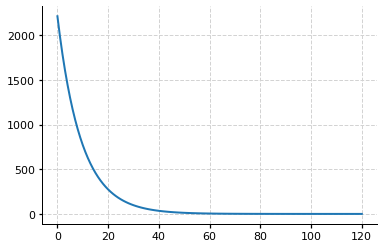

In [171]:
plt.plot(signif_wwz[:,2])

In [ ]:
signif-WWZ